In [1]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-06-22 15:44


## Clipping


In [2]:
def test_capacity_clipping(N, D, K=5, clip=10, trials=5e3):
    '''
    Runs a capacity experiment with noise in the dereferencing vector.
    '''
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    for i in range(int(trials)-1):
        
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]
        
        hypercapacity[hypercapacity > clip] = clip
        hypercapacity[hypercapacity < -clip] = -clip  

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [141]:
K=25
N = 2000
test_clip = [20, 30, 40, 50]

runs = 5

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_clipping(N, len(random_idx.alphabet), K=K, clip=clip)
        
        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-clip-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: Dep

Duration:  0.933390140533
Duration:  0.887745857239
Duration:  0.882421970367
Duration:  0.888551950455
1
Duration:  0.895421981812
Duration:  0.880882978439
Duration:  0.882802009583
Duration:  0.885728120804
2
Duration:  1.02518987656
Duration:  0.892016887665
Duration:  0.887481927872
Duration:  0.916567087173
3
Duration:  0.988338947296
Duration:  0.971935987473
Duration:  0.952442884445
Duration:  0.929182767868
4
Duration:  1.00128483772
Duration:  0.948257923126
Duration:  0.992266178131
Duration:  0.994506120682
data/capacity-clip-N=2000-tc=4-r=5-n160617.npz


In [142]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


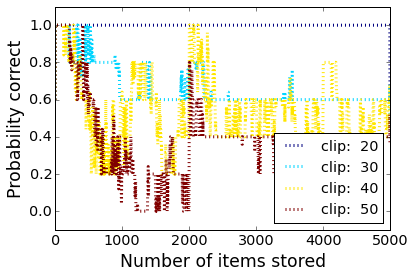

In [143]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=3, label="clip: %3d" % test_clip[i])


M = np.arange(li_mean.shape[0])

#for idx_clip, clip in enumerate(test_clip):
#    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
#    plot(M, p_correct, color=cm(idx_clip),lw=3, label="clip: %3d" % clip)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')
ylim([-0.1, 1.1])
savefig('figures/capacity_clipping-N=' + str(N) +'-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_clipping-N='+ str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

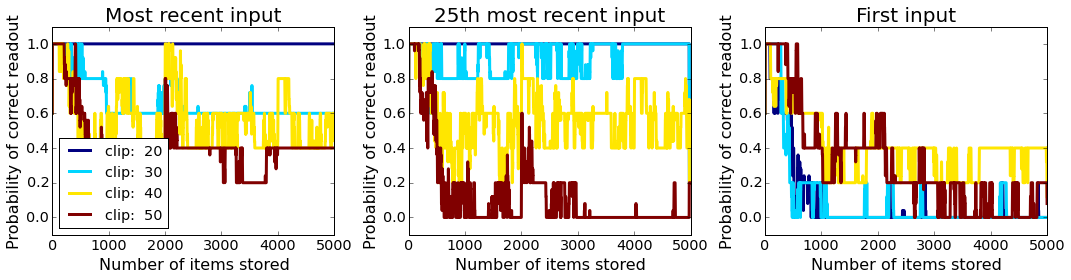

In [146]:
figure(figsize=(15,4))

subplot(131)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-smoothN//2], 
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
legend(loc='lower left');
title('Most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(132)
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-22],
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
#legend(loc='lower left');
title('%dth most recent input' % K, fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(133)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
#legend(loc='lower left');
title('First input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])
plt.tight_layout()

savefig('figures/capacity-clipping-recency-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clipping-recency-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [3]:
def test_capacity_clipping_lookback(N, D, clip=10, trials=25e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        hypercapacity[hypercapacity > clip] = clip
        hypercapacity[hypercapacity < -clip] = -clip
        
        v_last_input = np.roll(hypercapacity, -1)
        #v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    for i in range(int(trials)):
        v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

In [127]:
N = 5000
test_clip = [1, 3, 5, 10, 20, 40, 80]
#test_clip = arange(8) + 1

runs = 15

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

clip_mean_all = []
clip_var_all = []

lv = 2*(np.random.randn < 0) -1 

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_clipping_lookback(N, len(random_idx.alphabet), clip=clip)
        
        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
        clip_mean_all.append(np.dot(lv,hypvec))
        clip_var_all.append(var(hypvec))
        
        
filename = 'data/capacity-clip-lookback-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  10.7413630486
Duration:  10.1094510555
Duration:  9.99164199829
Duration:  9.66489696503
Duration:  9.45702314377
Duration:  9.40295505524
Duration:  9.38167595863
1
Duration:  10.391283989
Duration:  9.82570004463
Duration:  9.66720485687
Duration:  9.51653122902
Duration:  9.45754599571
Duration:  10.8569700718
Duration:  10.6251859665
2
Duration:  11.6526210308
Duration:  10.3314509392
Duration:  10.179338932
Duration:  9.70272779465
Duration:  9.61380910873
Duration:  10.3243589401
Duration:  9.8063659668
3
Duration:  10.3231117725
Duration:  9.78619408607
Duration:  9.62913799286
Duration:  9.54239702225
Duration:  9.43905997276
Duration:  9.37450289726
Duration:  9.34588694572
4
Duration:  10.2664418221
Duration:  9.79470205307
Duration:  9.66934204102
Duration:  9.49988603592
Duration:  9.43053007126
Duration:  9.38570094109
Duration:  9.35728907585
5
Duration:  10.253098011
Duration:  9.79188585281
Duration:  9.64146995544
Duration:  9.5136089325
Duration:  9.4447748

In [164]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
h = np.load('data/capacity-clip-lookback-N=5000-tc=7-r=15-n160623.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_clip = h['run_clip']
test_clip = h['test_clip']
runs = h['runs']
N = h['N']
D = h['D']
#K = h['K']

In [165]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_iK_all[i], 'int32')  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


(array([ 803.,  711.,  656.,  541.,  508.,  457.,  360.,  370.,  317.,  277.]),
 array([-80., -64., -48., -32., -16.,   0.,  16.,  32.,  48.,  64.,  80.]),
 <a list of 10 Patch objects>)

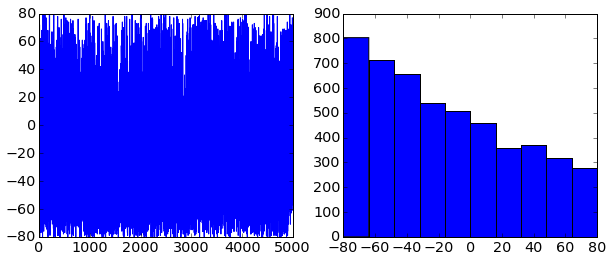

In [166]:
figure(figsize=(10,4))

subplot(121)
plot(hypvec)

subplot(122)
hist(hypvec)

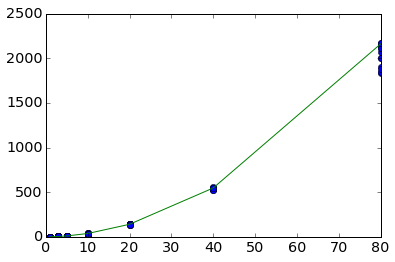

In [167]:
run_clip = np.array(run_clip)
clip_var_all = np.array(clip_var_all)
test_clip = np.array(test_clip)

plot(run_clip, clip_var_all, 'o')
plot(test_clip, ((2*test_clip+1) ** 2 - 1)/12)

In [168]:
import scipy
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_decay(M,ll=1, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = (1 / (1 - ll**2))
    
    for iM,Mval in enumerate(M):
        avals = np.linspace(N * ll ** Mval - 8 * (N*dM)**0.5, N * ll ** Mval + 8 * (N*dM)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N * ll ** Mval) / ((dM)*N)**0.5) - ncdf((avals[:-1]-N * ll ** Mval) / ((dM)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [169]:
def clip_decay2(lb, clip=5):
    '''
    Approximates the decay in the hit dot product when there is clipping. 
    '''
    
    # This is going to keep track of how many elements are a value between -clip and + clip
    # We assume that the hypervector is "filled" before a memory item is added. This means
    # that there is a uniform distribution across the values of each element.
    vec = np.ones(2*clip+1)
    
    # When we add a vector to remember, this distribution shifts. The clipping then
    # causes there to be one less element with value -clip, and one extra element
    # with value clip.
    vec[0] -= 1
    vec[-1] += 1
    
    decay = np.zeros(lb)
    
    for l in range(lb):
        # the sum of vec divided by the number of states is the amount the dot product 
        # is reduced.
        decay[l] = np.sum(vec * arange(-clip, clip+1)) / ((2*clip+1))
        
        vect = vec.copy()
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2

    return decay

        

In [170]:
def p_correct_clip(M,clip=5, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = ((2.0*clip+1) ** 2.0 -1.0) / 12.0
    
    decay = clip_decay2(max(M)+1, clip=clip)
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        #vval = vdecay[Mval] * N
        vval = dM * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

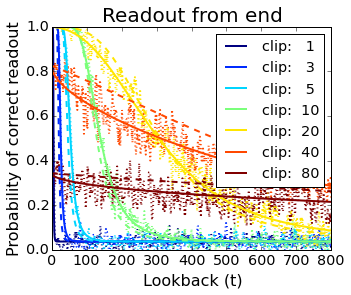

In [173]:
figure(figsize=(5,4))

cm=get_cmap('jet', iK_mean.shape[1])
smoothN=5
for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(iK_mean.shape[0], 0, -1)[:-5],
         np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-5],
         ':', color=cm(i), lw=2)
    
    #pcd = p_correct_decay(arange(iK_mean.shape[0])+1, ll=decay, N=N, D=test_D[i]) 
    #plot(arange(iK_mean.shape[0]), pcd, lw=3, color=cm(i))

test_ll = [0.5, 0.9552, 0.9875, 0.9975, 0.9992, 0.999755]
M = arange(1000)
cm = get_cmap('jet', len(test_clip))

#for il,ll in enumerate(test_ll):
for il, clip in enumerate(test_clip):
    ll = np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    plot(M, p_correct_clip(M, N=N, clip=clip), color=cm(il), lw=2, 
        label="clip: %3i" % test_clip[il])
    
legend(loc='upper right');
title(r'Readout from end', fontsize=20);
xlabel('Lookback (t)', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([1, 800])

#xscale('log')
#yscale('log')

#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)
savefig('figures/capacity-clipping-lookback' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clipping-lookback' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

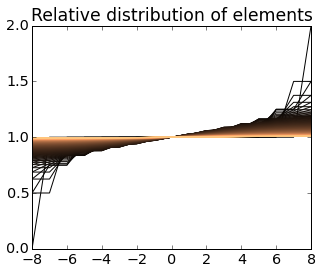

In [158]:
def clip_decay_plot(lb, clip=5):
    vec = np.ones(2*clip+1)
    
    vec[0] -= 1
    vec[-1] += 1
    
    decay = np.zeros(lb)
    cm = get_cmap('copper', lb)
    
    for l in range(lb):
        
        #print np.array_str(vec, precision=2)
        #if mod(l, 1) == 0:
        plot(arange(-clip, clip+1), vec, color=cm(l))
        
        decay[l] = np.sum(vec * arange(-clip, clip+1)) / ((2*clip+1))
        
        vect = vec.copy()
        
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2
        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
        #plot(arange(-clip, clip+1), vec)
        
    return decay


clip=8
lookback = 200
figure(figsize=(5,4))
decay = clip_decay_plot(lookback, clip=clip)
title('Relative distribution of elements')

In [149]:
test_clip=[3, 4, 5, 6, 7]
lookback=4
for clip in test_clip:
    clip_decay_plot(lookback, clip=clip)
    print ''
    
    

[ 0.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  1.    1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.12  1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.    1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.    1.    1.12  1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.    1.    1.    1.    1.25  1.25
  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.    1.    1.    1.    1.12  1.12  1.38
  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.   1.   1. 

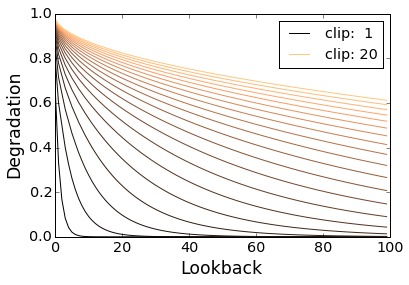

In [162]:
test_clip = arange(20)+1

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(clip_decay2(100, clip=clip), color=cm(ic))
    else:
        plot(clip_decay2(100, clip=clip), color=cm(ic), label='clip: %2i'%clip)
    
legend()
ylabel('Degradation')
xlabel('Lookback')


In [582]:
test_clip

array([ 1,  3,  5, 10, 20, 40, 80])

In [211]:
ll

0.006211180124223602

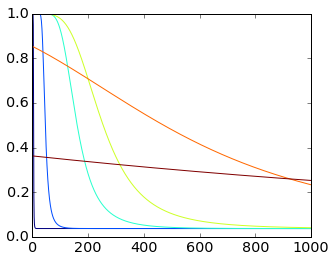

In [197]:
test_ll = [0.5, 0.95, 0.99, 0.995, 0.999, 0.99975]
M = arange(1000)
cm = get_cmap('jet', len(test_ll))

figure(figsize=(5,4))
for il,ll in enumerate(test_ll):
    plot(M, p_correct_decay(M, N=N, ll=ll), color=cm(il))

## Comparison to Eigenvalue

In [137]:
def test_capacity_decay_lookback(N, D, decay=1, trials=25e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        #v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    for i in range(int(trials)):
        v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

In [139]:
test_N = [2000, 5000]
test_D = [8]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []



for r in range(runs):
    print r
    for N in test_N:
        decay=1-exp(1/2)*25/N
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_decay_lookback(N, D, decay=decay)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        



0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  4.37567901611
Duration:  8.588296175
1
Duration:  4.02849411964
Duration:  7.43607401848
2
Duration:  4.25706005096
Duration:  7.20579600334
3
Duration:  3.75474715233
Duration:  7.59370684624
4
Duration:  3.74104499817
Duration:  8.28810191154


(array([    8.,    41.,   205.,   697.,  1300.,  1380.,   908.,   342.,
           98.,    21.]),
 array([-29.43611914, -23.80149058, -18.16686202, -12.53223345,
         -6.89760489,  -1.26297633,   4.37165224,  10.0062808 ,
         15.64090936,  21.27553792,  26.91016649]),
 <a list of 10 Patch objects>)

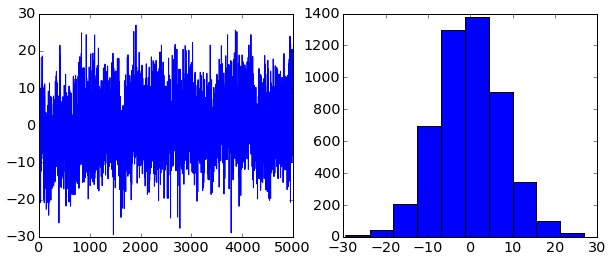

In [140]:
figure(figsize=(10,4))

subplot(121)
plot(hypvec)

subplot(122)
hist(hypvec)

In [423]:
test_clip = [1]
test_N = [1000, 2000, 4000]

test_means = np.zeros((len(test_clip), len(test_N)))
test_vars = np.zeros((len(test_clip), len(test_N)))

for ic,clip in enumerate(test_clip):
    for iN,N in enumerate(test_N):
        filled_hypvec = np.round((2*clip+1)*np.random.rand(N, 500) - clip - 0.5)
        lv = 2 * (np.random.randn(N) < 0) - 1

        res = np.dot(lv.T, filled_hypvec)
        
        test_means[ic, iN] = mean(res)
        test_vars[ic, iN] = var(res)
        

(array([ 1373.,     0.,     0.,     0.,     0.,  1338.,     0.,     0.,
            0.,  1289.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

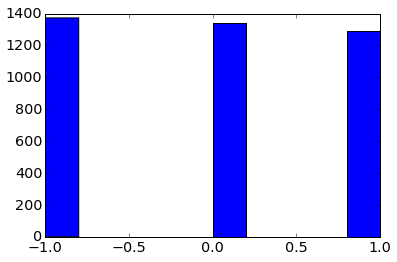

In [422]:
hist(filled_hypvec[:,1])

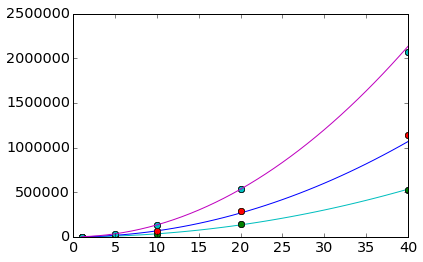

In [262]:

for iN in range(len(test_N)):
    plot(test_clip, test_vars, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    plot(clipx, test_N[iN] * clipx ** 2 / 3)

In [502]:
test_clip = [1, 2, 3, 4, 5, 10, 20]
test_N = [4000]

samps = 1000
lookback = 500

testh_means = np.zeros((len(test_clip), len(test_N), lookback))
testh_vars = np.zeros((len(test_clip), len(test_N), lookback))


for ic,clip in enumerate(test_clip):
    tstart = time.time()
    
    for iN,N in enumerate(test_N):
        filled_hypvec = np.round((2*clip+1)*np.random.rand(N, samps) - clip - 0.5)
        lv = 2 * (np.random.randn(N) < 0) - 1
        
        filled_hypvec += tile(lv.T, (samps,1)).T
        
        filled_hypvec[filled_hypvec > clip] = clip
        filled_hypvec[filled_hypvec < -clip] = -clip
        
        for l in range(lookback):
            res = np.dot(lv.T, filled_hypvec)
        
            testh_means[ic, iN, l] = mean(res)
            testh_vars[ic, iN, l] = var(res)
            
            filled_hypvec += 2 * (np.random.randn(N, samps) < 0) - 1
            
            filled_hypvec[filled_hypvec > clip] = clip
            filled_hypvec[filled_hypvec < -clip] = -clip

    print clip, ' Duration: ', time.time() - tstart
        

1  Duration:  150.099540949
2  Duration:  148.328685999
3  Duration:  147.632040977
4  Duration:  148.280220032
5  Duration:  143.914530993
10  Duration:  141.117695093
20  Duration:  135.80488801


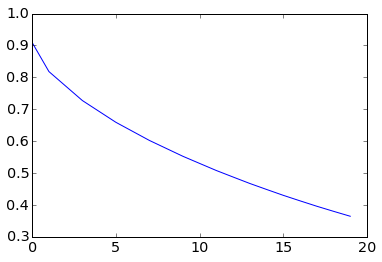

In [530]:
def clip_decay(lb, clip=5):
    vec = arange(-clip, clip+1)
    vec += 1
    
    decay = np.zeros(lb)
    
    for l in range(lb):
        vec[vec > clip] = clip
        vec[vec < -clip] = -clip
        
        decay[l] = vec.sum() / ((2*clip+1)*2**l)
        
        vecp = vec + 1
        vecn = vec - 1
        
        vec = vstack((vecp, vecn))
        
    return decay
plot(clip_decay(20))
        
        

(0, 10)

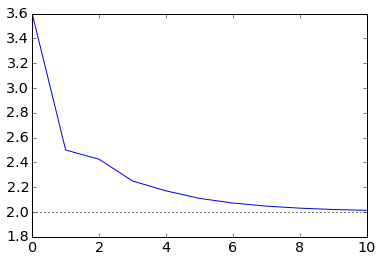

In [659]:
def clip_decay_var(lb, clip=5):
    vec = np.ones(2*clip+1)
    
    vec[0] -= 1
    vec[-1] += 1
    
    vdecay = np.zeros(lb)
    
    for l in range(lb):
        
        #print np.array_str(vec, precision=2)
        #if mod(l, 2) == 0:
        #    plot(arange(-clip, clip+1), vec)
        
        vdecay[l] = np.sum((vec * arange(-clip, clip+1))**2) / ((2*clip+1))
        
        vect = vec.copy()
        
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2
        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
        #plot(arange(-clip, clip+1), vec)
        
    return vdecay


#plot(clip_decay(20))
#plot(clip_decay2(20))
     
clip = 2
plot(clip_decay_var(500, clip=clip))
plot([0, 500], [((2*clip+1)**2-1)/12, ((2*clip+1)**2-1)/12], ':k')        
xlim([0,10])

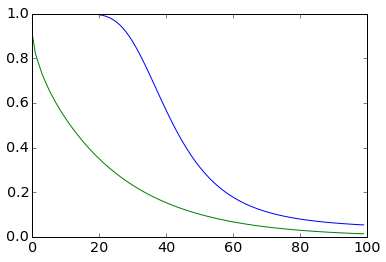

In [676]:
clip=5

plot(p_correct_clip(arange(100), N=2000, clip=clip))
plot(clip_decay2(100, clip=clip))

In [646]:
d = p_correct_clip(arange(10), N=2000, clip=2)

In [647]:
print d

[  8.94131383e-01   1.63447867e-05   6.95443703e-13   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


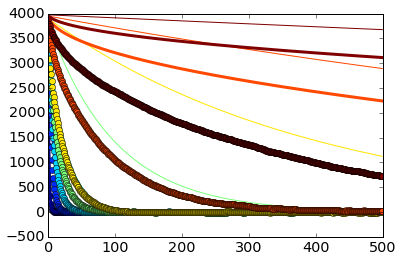

In [586]:
cm = get_cmap('jet', len(test_clip))

for ic in range(len(test_clip)):
    for iN in range(len(test_N)):
        plot(arange(lookback), testh_means[ic, iN, :], 'o', color=cm(ic))
        
        ll = 1 - 1/(test_clip[ic]**2 + 1)
        
        plot(arange(lookback), test_N[iN] * (1 - 1/(2*test_clip[ic]+1)) * ll ** arange(lookback), color=cm(ic))
        plot(arange(lookback), test_N[iN] * clip_decay2(lookback, test_clip[ic]),
             color=cm(ic), lw=3)
#xlim([0,20])

(0, 100)

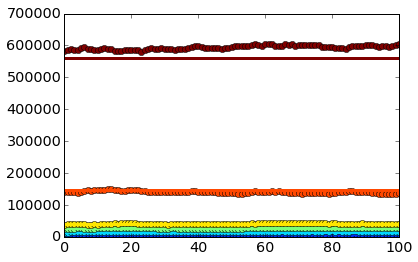

In [515]:
cm = get_cmap('jet', len(test_clip))

for ic in range(len(test_clip)):
    for iN in range(len(test_N)):
        plot(arange(lookback), testh_vars[ic, iN, :], 'o', color=cm(ic))
        plot(arange(lookback), np.ones(lookback)* test_N[iN] * (2*test_clip[ic]+1) ** 2 / 12, color=cm(ic), lw=3)
           
xlim([0,100])


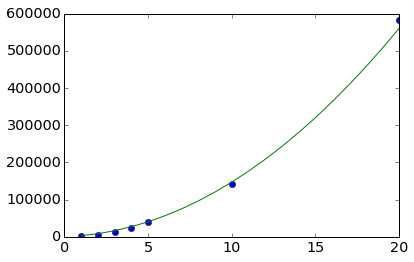

In [516]:

for iN in range(len(test_N)):
    plot(test_clip, testh_vars[:, iN, 0], 'o')
    clipx = np.arange(1, max(test_clip)+1)
    plot(clipx, test_N[iN] * (2*clipx+1) ** 2 / 12)
    


ValueError: x and y can be no greater than 2-D

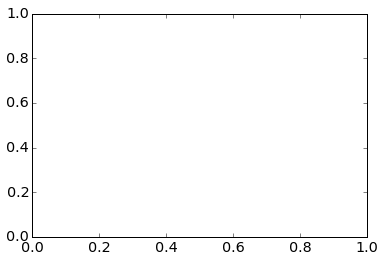

In [517]:

for iN in range(len(test_N)):
    plot(test_clip, testh_means, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    #plot(clipx, test_N[iN] * (1 - 1/(clipx**2+1))**((lookback+1)))
    plot(clipx, test_N[iN]* (1 - 1.0/(2*clipx+1)) * (1-1.0/(clipx**2+1))** ((lookback)) )

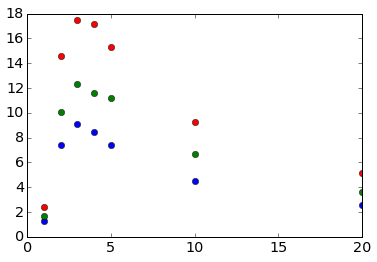

In [349]:

for iN in range(len(test_N)):
    plot(test_clip, testh_means[:, iN] / testh_vars[:, iN]**0.5, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    #plot(clipx, test_N[iN] * (1 - 2/(2*clipx**2+1))**((lookback+1)))

In [256]:
print mean(noise_dist), var(noise_dist)

-2.55 676125.8875
